# About this notebook  
- PyTorch resnext50_32x4d starter code  
- StratifiedKFold 5 folds  
- training code is [here](https://www.kaggle.com/yasufuminakama/cassava-resnext50-32x4d-starter-training)

If this notebook is helpful, feel free to upvote :)

# Directory settings

In [218]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
MODEL_DIR = '../input/efficientnet/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = '../input/cassava-leaf-disease-classification/train_images'
TEST_PATH = '../input/cassava-leaf-disease-classification/train_images'

# CFG

In [219]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    num_workers=4
    model_name='tf_efficientnet_b3_ns'
    size=256
    batch_size=32
    seed=42
    target_size=5
    target_col='label'
    n_fold=5
    trn_fold=[0, 1, 2]
    train=False
    inference=True

# Library

In [220]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, GaussNoise
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [221]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'inference.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

#LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# Data Loading

In [222]:
test = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv').head(1000)
test.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


# Dataset

In [277]:
# ====================================================
# Dataset
# ====================================================
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TEST_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image,label
#         return image

# Transforms

In [292]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop(CFG.size, CFG.size),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            GaussNoise(var_limit=5, mean=0,  always_apply=False, p=1),
            ToTensorV2(),
        ])

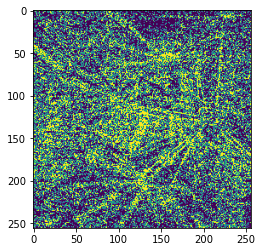

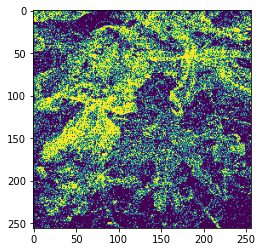

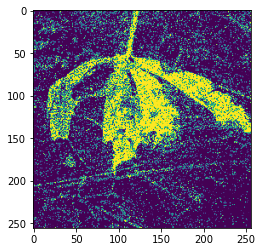

In [293]:
from matplotlib import pyplot as plt

test_dataset = TestDataset(test, transform=get_transforms(data='valid'))

for i in [1,5,8]:
    image,label = test_dataset[i]
    plt.imshow(image[0])
    plt.show() 

# MODEL

In [270]:
# ====================================================
# MODEL
# ====================================================
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

    
class CustomEfficientNet(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(CFG.model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

# Helper functions

In [271]:
# ====================================================
# Helper functions
# ====================================================
def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# inference

In [272]:
# ====================================================
# inference
# ====================================================
model = CustomEfficientNet(CFG.model_name, pretrained=False)
states = [torch.load(MODEL_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth') for fold in CFG.trn_fold]
test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, 
                         num_workers=CFG.num_workers, pin_memory=True)
predictions = inference(model, states, test_loader, device)
# submission

test['pred'] = predictions.argmax(1)

test[['image_id', 'label',"pred"]].to_csv(OUTPUT_DIR+'result.csv', index=False)
test.head()

,image_id,label,pred
0,1000015157.jpg,0,1
1,1000201771.jpg,3,1
2,100042118.jpg,1,4
3,1000723321.jpg,1,1
4,1000812911.jpg,3,4


In [273]:
ytrue = test["label"].tolist()
ypred = test["pred"].tolist()
get_score(ytrue, ypred)

0.276

In [274]:
from sklearn import metrics as skm
skm.f1_score(ytrue, ypred, average = "weighted")

0.2980353304659498

In [275]:
test

,image_id,label,pred
0,1000015157.jpg,0,1
1,1000201771.jpg,3,1
2,100042118.jpg,1,4
3,1000723321.jpg,1,1
4,1000812911.jpg,3,4
...,...,...,...
995,1172047582.jpg,3,1
996,1172185263.jpg,3,1
997,1172216777.jpg,3,1
998,117226420.jpg,3,3
